# **Effect of Coarser Meshes on Velocity Profiles**

This work is created by referring to [the notebook](https://github.com/AndreWeiner/phd_notebooks/blob/master/notebooks/animate_fluxes.ipynb) written by Dr.-Ing. Andre Weiner.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.integrate import trapz
from math import exp

# parameters for uniform plot appearance
fontsize_label = 24
fontsize_legend = 20
fontsize_tick = 20
line_width = 3

%matplotlib inline
rc('text', usetex=True)
alpha = 0.3
lw = line_width

In [2]:
# Constants
KAPPA = 0.41
E = 9.8
nu = 1.388e-5

# Function of Spalding's law for plotting
def spaldings_law(u_plus, E=E, kappa=KAPPA):
    """Evaluate Spalding's law of the wall.
    
    Parameters
    ----------
    u_plus - float: velocity along surface at distance y_plus in wall units
    E - float: wall roughness parameter
    kappa - float: von Kármán constant
    
    Returns
    -------
    y_plus - float: distance normal to wall in wall units
    
    """
    return u_plus + 1.0/E * (
        np.exp(kappa*u_plus) - 1.0 - kappa*u_plus - (kappa*u_plus)**2/2.0 - (kappa*u_plus)**3/6.0
    )

In [3]:
# u_tau, and tolerance of Bisection method
TOLERANCE = 1e-8
u_tau = 3.0

# Function for finding velocity by Bisection method
def spalding_velocity(y, u_tau, nu, tolerance=TOLERANCE, max_iter=100, E=E, kappa=KAPPA):
    """Invert Spalding's law to compute physical velocity.
    
    Spalding's law provides a relationship between the distance normal
    to the wall and the velocity along the wall in wall units. If the
    task is to compute the velocity with physical units for a given distance
    from the wall, it is not possible to invert Spalding's law analytically.
    This function computes the inverse relationship numerically using 
    "Bisection method".
    
    Parameters
    ----------
    y - float: distance normal to the wall in [m]
    u_tau - float: wall shear stress velocity in [m/s]
    nu - float: kinematic viscosity in [m^2/s]    
    tolerance - float: tolerance for iterative inversion
    max_iter - int: maximum allowed number of iterations
    E - float: wall roughness parameter
    kappa - float: von Kármán constant    
    
    Returns
    -------
    u - float: velocity along the wall at distance y in [m/s]
    
    """
    u = u_tau
    n_iter = 0
    residual = 1.0    
    
    u_upper = u_tau * 100.0
    u_lower = 0.0
    while residual > tolerance and n_iter < max_iter:
        u = 0.5 * (u_upper + u_lower)
        f_upper = spaldings_law(u_upper/u_tau) - y*u_tau/nu
        f_center = spaldings_law(u/u_tau) - y*u_tau/nu
        if f_center * f_upper > 0.0:
            u_upper = u
        else:
            u_lower = u
        residual = abs(f_center)
        n_iter += 1            
    return u

# y+ value of the end of the region
yplus = 200
# Limit value of the region in y-axis 
y_limit = yplus*nu/u_tau
y_plot = np.linspace(0, y_limit, 100)
u_plot = [spalding_velocity(y_plot[i], u_tau, nu) for i in range(len(y_plot))]

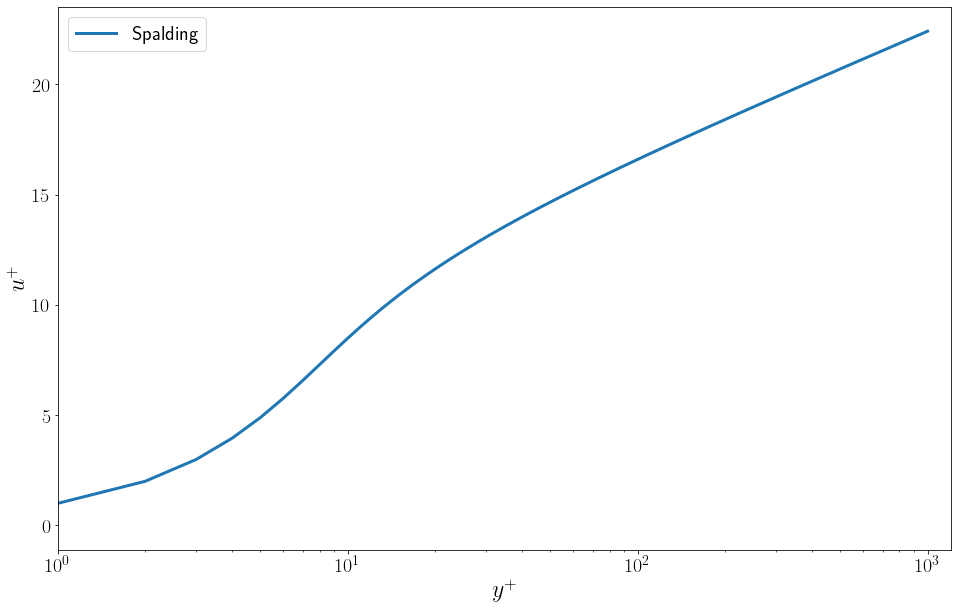

In [4]:
# Verification if the Spalding's function is implemented correctly
yp = np.linspace(0, 1000, 1000)
yp_temp = yp*nu/u_tau
up = [spalding_velocity(yp_temp[i], u_tau, nu)/u_tau for i in range(len(yp_temp))]

fig, ax_v = plt.subplots(1, 1, figsize=(16, 10.0))
ax_v.tick_params(labelsize=fontsize_tick)
ax_v.set_xscale("log")
ax_v.set_xlim([1, 1200])
ax_v.set_xlabel(r"$y^+$", fontsize=fontsize_label)
ax_v.set_ylabel(r"$u^+$", fontsize=fontsize_label)
ax_v.plot(yp, up, ls='-', c='C0', linewidth=lw, label="Spalding")
ax_v.legend(fontsize=fontsize_legend)

In [5]:
# In the functions, all input x is actually the y-coordinate, and input y corresponds to the velocity of x-direction.
def compute_derivative(x, y):
    dev_inner = [ (y[i-1] - y[i+1]) / (x[i-1] - x[i+1]) for i in range(1, x.shape[0]-1) ]
    dev_0 = [(y[0] - y[1]) / (x[0] - x[1])]
    dev_1 = [(y[-2] - y[-1]) / (x[-2] - x[-1])]
    return np.asarray(dev_0 + dev_inner + dev_1)

def compute_cell_average(n_cells, n_p, ind):
    cell_width = y_limit/n_cells
    fi = [0]
    while fi[-1] + cell_width < y_limit:
        fi.append(fi[-1] + cell_width)
    fi.append(y_limit)
    y_av = []
    for cell in range(0, len(fi)-1):
        x_cell = np.linspace(fi[cell], fi[cell+1], n_p)        
        y_cell = [spalding_velocity(x_cell[i], u_tau, nu) for i in range(n_p)]        
        y_av.append(trapz(y_cell, x_cell) / (fi[cell+1] - fi[cell]))
    return np.asarray(y_av)    

def interpolate_2nn(x, y, x_p):
    diff = np.absolute(x - x_p)
    ind_sort = np.argsort(diff)
    w_1 = 1.0 / (diff[ind_sort[0]] + 1.0E-15)
    w_2 = 1.0 / (diff[ind_sort[1]] + 1.0E-15)
    val = (y[ind_sort[0]] * w_1 + y[ind_sort[1]] * w_2) / (w_1 + w_2)
    return val

def compute_discretization_error(x, y, n_cells, ind):
    y_av = compute_cell_average(n_cells, 100, ind)    
    y_dev = compute_derivative(x, y)
    cell_width = y_limit / n_cells
    m_0_lin = (y_av[0] - y_limit) / cell_width * 2    
    m_1_lin = (y_av[1] - y_av[0]) / cell_width
    val_1_lin = 0.5 * (y_av[0] + y_av[1])
    m_1_ref =  interpolate_2nn(x, y_dev, cell_width)
    val_1_ref = interpolate_2nn(x, y, cell_width)
    return y_dev[0] - m_0_lin, m_1_ref - m_1_lin, val_1_ref - val_1_lin

def create_base_plot(ref_label):
    fig = plt.figure(figsize=(16, 10.0))
    grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.3)
    ax1 = plt.subplot(grid[0, :])
    ax2 = plt.subplot(grid[1, 0])
    ax3 = plt.subplot(grid[1, 1])
    ax4 = plt.subplot(grid[1, 2])
    # upper plot
    ax1.plot([], [], ls='-', c='C0', linewidth=lw, label=ref_label)
    ax1.set_xlabel(r"$y$", fontsize=fontsize_label)
    ax1.tick_params(labelsize=fontsize_tick)
    ax1.set_xlim([0.0, y_limit])
    ax1.set_ylim([0.0, 70.0])
    ax1.legend(fontsize=fontsize_legend, loc=1)
    # lower plots
    labels = [r"$(\mathrm{d}_y U_{ref} -\mathrm{d}_y U_{num})_{wall}$",
          r"$(\mathrm{d}_y U_{ref} -\mathrm{d}_y U_{num})_{f_1}$",
          r"$(U_{ref} - U_{num})_{f_1}$"]
    for ax, label in zip([ax2, ax3, ax4], labels):
        ax.set_yticks([0.0])
        ax.axhline(0.0, lw=2, color="k", ls=":")
        ax.set_xlabel(r"\# of cells in the region", fontsize=fontsize_label)
        ax.tick_params(labelsize=fontsize_tick)        
        ax.plot([], [], lw=lw, color="C3", ls=":", label=label)
        ax.legend(fontsize=fontsize_legend, loc='lower center', bbox_to_anchor=(0.5, -0.5))
    return fig, ax1, ax2, ax3, ax4

def text_formatter(number):
    if number < 10:
        return "{:2.3f}".format(number)
    else:
        return "{:2.2f}".format(number)

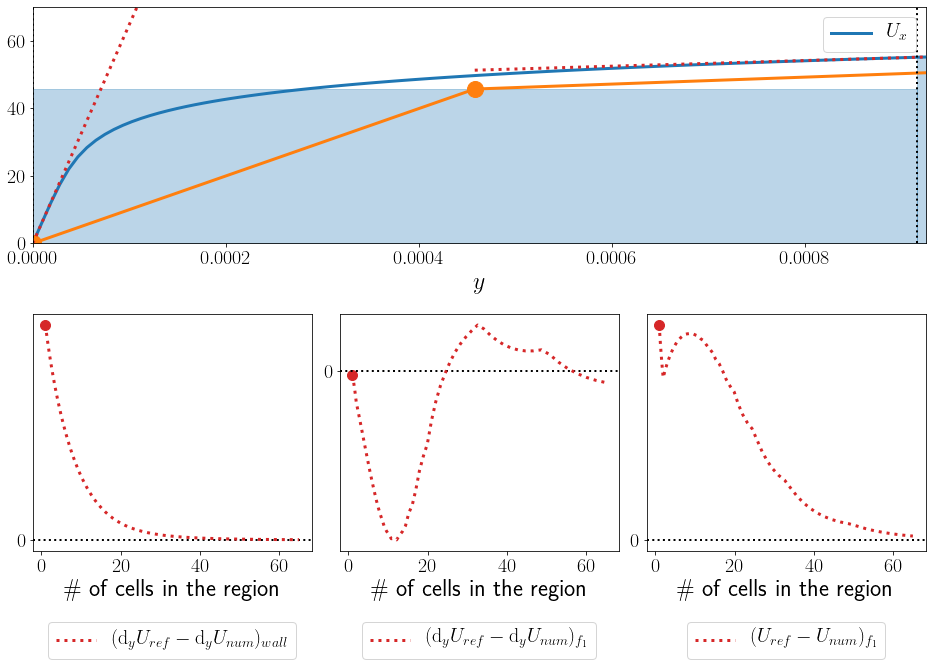

In [6]:
fig, ax1, ax2, ax3, ax4 = create_base_plot(ref_label=r"$U_x$")

frames = 100
n_cells_array = 1.01 + np.power(np.linspace(0, 1, frames), 4) * (65.0 - 1.01)
n_cells_array = np.append(n_cells_array, n_cells_array[-2::-1])
bbox = dict(facecolor='white', alpha=1.0, boxstyle='round,pad=0.5')
dev_u = compute_derivative(y_plot, u_plot)

diff_m_0 = []
diff_m_1 = []
diff_v_1 = []
for nc in n_cells_array:
    m_0, m_1, v_1 = compute_discretization_error(y_plot, u_plot, nc, 0)
    diff_m_0.append(m_0)
    diff_m_1.append(m_1)
    diff_v_1.append(v_1)
    
dot_plot = [
    ax2.scatter([], [], marker="o", color="C3", s=100),
    ax3.scatter([], [], marker="o", color="C3", s=100),
    ax4.scatter([], [], marker="o", color="C3", s=100)
]

# reference solution
ax1.plot(y_plot, u_plot, ls='-', c='C0', linewidth=lw)
# discretization error plot
ax2.plot(n_cells_array[:frames], diff_m_0[:frames], lw=lw, color="C3", ls=":")
ax3.plot(n_cells_array[:frames], diff_m_1[:frames], lw=lw, color="C3", ls=":")
ax4.plot(n_cells_array[:frames], diff_v_1[:frames], lw=lw, color="C3", ls=":")

# references to elements which will be updated/deleted during the animation
faces_ind = []
fills = []
approx_line, = ax1.plot([], [], c='C1', linewidth=lw, marker="o", ms=16)
tangent_0, = ax1.plot([], [], ls=":", c="C3", linewidth=lw)
tangent_1, = ax1.plot([], [], ls=":", c="C3", linewidth=lw)

def update(frame):
    n_cells = n_cells_array[frame]
    cell_width = y_limit / n_cells
    # plot cells and cell averages
    cell_av = compute_cell_average(n_cells, 10, 0)
    for ind in faces_ind[::-1]:
        del ax1.lines[ind]
    del faces_ind[:]
    for area in fills:
        area.remove()
    del fills[:]
    start = len(ax1.lines)
    for fi, av_i in enumerate(cell_av):
        faces_ind.append(start)
        start += 1
        ax1.axvline(y_limit/n_cells*fi, 0, 1, linestyle=':', color='k', lw=2)
        fills.append(ax1.fill_between([y_limit/n_cells*fi, y_limit/n_cells*(fi+1)], [0.0, 0.0], [av_i, av_i],
                                      color="C0", alpha=alpha))
    # linear approximation
    approx_line.set_data([0.0, 0.5*cell_width, 1.5*cell_width], [y_limit, cell_av[0], cell_av[1]])
    # tangents at zeros and first cell boundary
    tangent_0.set_data([0.0, 0.5 * cell_width], [y_limit, y_limit + 0.5 * cell_width * dev_u[0]])
    m_1 = interpolate_2nn(y_plot, dev_u, cell_width)
    val_1 = interpolate_2nn(y_plot, u_plot, cell_width)
    tangent_1.set_data([0.5*cell_width, 1.5*cell_width], [val_1 - 0.5 * cell_width * m_1, val_1 + 0.5 * cell_width * m_1])    
    # update discretization error
    dot_plot[0]._offsets = np.c_[[n_cells], [interpolate_2nn(n_cells_array, diff_m_0, n_cells)]]
    dot_plot[1]._offsets = np.c_[[n_cells], [interpolate_2nn(n_cells_array, diff_m_1, n_cells)]]
    dot_plot[2]._offsets = np.c_[[n_cells], [interpolate_2nn(n_cells_array, diff_v_1, n_cells)]]
    
output_path = "./output/spalding/"
!mkdir -p {output_path}

for frame in range(2*frames-1):
    update(frame) 
    plt.savefig(output_path + "spalding_{:03d}.png".format(frame), dpi=100, bbox_inches="tight")